# MCU Benchmark Analysis

This notebook analyzes TinyML benchmark results for microcontroller (MCU) platforms, focusing on:
1. **Data Reading and Preprocessing**: Load and standardize CSV data
2. **Success Rate Plotting**: Visualize model success rates across stages
3. **Model Cost/Time Plotting**: Compare execution time and operational costs

## 1. Data Reading and Preprocessing

Load CSV files, standardize columns, and compute derived metrics for analysis.

### 1.1 Load and Standardize Data

In [5]:
from pathlib import Path
import pandas as pd
import numpy as np

# Resolve data directory (works from repo root or notebook folder)
DATA_DIR = Path().resolve()
 

# Canonical labels and ordering (single source of truth)
MODEL_LABELS = {
    "gpt-5": "G5",
    "gpt-4o": "G4o",
    "gpt-4o-mini": "G4o-m",
    "phi4": "Phi4",
    "qwen32": "Qw32B",
    "qwen14": "Qw14B",
    "codestral": "Co22B",
    "gemma3": "Ge3",
}
PROCESSOR_LABELS = { "dp": "DP",
                    "mc": "MC",  
                    "sg": "SG",
                    "psg": "PSG", 
                    "tpusg": "TPUSG"}

MODEL_ORDER_PREF = list(MODEL_LABELS.keys())


PROCESSOR_ORDER_PREF = list(PROCESSOR_LABELS.keys())

 
# Load single consolidated CSV file
csv_path = DATA_DIR / "all-MPU.csv"
if not csv_path.exists():
    raise FileNotFoundError(f"File not found: {csv_path}")

# Read and preprocess data
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()

# Check for required columns
required_cols = {"status", "latency", "processor", "model"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"CSV is missing required columns: {sorted(missing)}")

# Standardize and clean data
df = df.copy()
df["status"] = df["status"].astype(str).str.strip().str.lower()
df["status_group"] = np.where(df["status"] == "success", "success", "failure")
df["processor_std"] = df["processor"].astype(str).str.strip().str.lower()
df["model_std"] = df["model"].astype(str).str.strip().str.lower()

# Add total_cost if not present
if "total_cost" not in df.columns:
    df["total_cost"] = np.nan

print(f"Loaded data from: {csv_path.name}")
print(f"Total rows: {len(df)}")
print(f"Columns: {list(df.columns)}")


Loaded data from: all-MPU.csv
Total rows: 660
Columns: ['name', 'trace_id', 'batch_id', 'status', 'latency', 'total_tokens', 'prompt_tokens', 'completion_tokens', 'total_cost', 'prompt_cost', 'completion_cost', 'parameters', 'processor', 'model', 'status_group', 'processor_std', 'model_std']


### 1.2 Compute Derived Metrics

In [6]:
import pprint

# ═══════════════════════════════════════════════════════════════════════════
# STEP 1: Determine model and processor order
# ═══════════════════════════════════════════════════════════════════════════
models_present = list(df["model_std"].unique())
processors_present = list(df["processor_std"].unique())

model_order = [m for m in MODEL_ORDER_PREF if m in models_present] + [
    m for m in models_present if m not in MODEL_ORDER_PREF
]
processor_order = [p for p in PROCESSOR_ORDER_PREF if p in processors_present] + [
    p for p in processors_present if p not in PROCESSOR_ORDER_PREF
]

# ═══════════════════════════════════════════════════════════════════════════
# STEP 2: Calculate success rates
# ═══════════════════════════════════════════════════════════════════════════
pivot_data = (
    df.groupby(["model_std", "processor_std", "status_group"])
    .size()
    .unstack(fill_value=0)
)

for missing_col in ("success", "failure"):
    if missing_col not in pivot_data.columns:
        pivot_data[missing_col] = 0

success_rate_dict = {}
for (model, processor), row in pivot_data.iterrows():
    success_count = int(row.get("success", 0))
    failure_count = int(row.get("failure", 0))
    total = success_count + failure_count
    rate = success_count / total if total else 0.0
    success_rate_dict[(model, processor)] = {
        "success_count": success_count,
        "failure_count": failure_count,
        "total": total,
        "success_rate": rate,
    }

print("Success rate summary (fraction):")
pprint.pprint(success_rate_dict)

# ═══════════════════════════════════════════════════════════════════════════
# STEP 3: Aggregate latency and cost metrics by model
# ═══════════════════════════════════════════════════════════════════════════
def _agg_mean(frame: pd.DataFrame, metric: str):
    """Aggregate mean of a metric grouped by processor."""
    if frame.empty or metric not in frame:
        return {p: 0.0 for p in processor_order}
    return (
        frame.groupby("processor_std")[metric]
        .mean()
        .reindex(processor_order)
        .fillna(0.0)
        .to_dict()
    )


def build_model_dict(model_key: str):
    """Build latency and cost statistics for a given model."""
    subset = df[df["model_std"] == model_key]
    if subset.empty:
        return {"latency": {}, "cost": {}}

    df_pass = subset[subset["status_group"] == "success"]
    df_fail = subset[subset["status_group"] != "success"]

    pass_latency = _agg_mean(df_pass, "latency")
    fail_latency = _agg_mean(df_fail, "latency")
    pass_cost = _agg_mean(df_pass, "total_cost")
    fail_cost = _agg_mean(df_fail, "total_cost")

    def safe_mean(frame, metric):
        if frame.empty or frame[metric].dropna().empty:
            return 0.0
        return float(frame[metric].mean())

    return {
        "latency": {
            **pass_latency,
            "total": safe_mean(df_pass, "latency"),
            "total_x": safe_mean(df_fail, "latency"),
        },
        "cost": {
            **pass_cost,
            "total": safe_mean(df_pass, "total_cost"),
            "total_x": safe_mean(df_fail, "total_cost"),
        },
    }

# ═══════════════════════════════════════════════════════════════════════════
# STEP 4: Select GPT models for comparison and build their statistics
# ═══════════════════════════════════════════════════════════════════════════
models_by_volume = df["model_std"].value_counts().index.tolist()
gpt_models = [m for m in models_by_volume if "gpt" in m.lower()]
if not gpt_models:
    raise ValueError("No models containing 'gpt' found for comparison plot.")

primary_model = gpt_models[0]
secondary_model = gpt_models[1] if len(gpt_models) > 1 else None

primary_stats = build_model_dict(primary_model)
secondary_stats = build_model_dict(secondary_model) if secondary_model else None

# ═══════════════════════════════════════════════════════════════════════════
# STEP 5: Scale cost values for better visualization (convert to cents)
# ═══════════════════════════════════════════════════════════════════════════
COST_SCALE = 100
primary_stats["cost"] = {k: (v or 0) * COST_SCALE for k, v in primary_stats["cost"].items()}
if secondary_stats:
    secondary_stats["cost"] = {k: (v or 0) * COST_SCALE for k, v in secondary_stats["cost"].items()}

print("\n" + "="*80)
print("Primary model:", MODEL_LABELS.get(primary_model, primary_model))
print("="*80)
pprint.pprint(primary_stats)
if secondary_stats:
    print("\n" + "="*80)
    print("Secondary model:", MODEL_LABELS.get(secondary_model, secondary_model))
    print("="*80)
    pprint.pprint(secondary_stats)

Success rate summary (fraction):
{('codestral', 'psg'): {'failure_count': 49,
                        'success_count': 11,
                        'success_rate': 0.18333333333333332,
                        'total': 60},
 ('codestral', 'tpusg'): {'failure_count': 42,
                          'success_count': 18,
                          'success_rate': 0.3,
                          'total': 60},
 ('gemma3', 'psg'): {'failure_count': 19,
                     'success_count': 41,
                     'success_rate': 0.6833333333333333,
                     'total': 60},
 ('gemma3', 'tpusg'): {'failure_count': 58,
                       'success_count': 2,
                       'success_rate': 0.03333333333333333,
                       'total': 60},
 ('gpt-5', 'psg'): {'failure_count': 1,
                    'success_count': 29,
                    'success_rate': 0.9666666666666667,
                    'total': 30},
 ('gpt-5', 'tpusg'): {'failure_count': 3,
                      's

## 2. Success Rate Plotting

Visualize success rates for each model across different processor stages using a heatmap with progress bars.

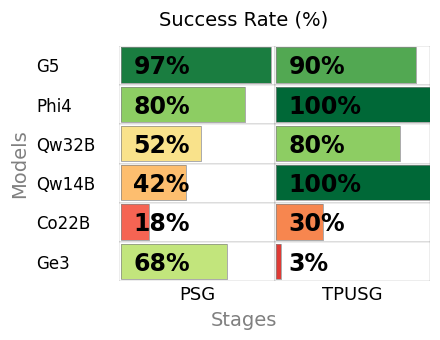

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams["font.family"] = "DejaVu Sans"

# Build dataframe again to stay in sync even if previous cell is skipped
heatmap_df = pd.DataFrame(
    [
        {
            "model": MODEL_LABELS.get(model, model),
            "processor": processor,
            "success_rate": (data["success_rate"] * 100)
            if data["success_rate"] <= 1
            else data["success_rate"],
        }
        for (model, processor), data in success_rate_dict.items()
    ],
)

heatmap_df = heatmap_df.pivot(index="model", columns="processor", values="success_rate")
heatmap_df = heatmap_df.reindex(
    index=[MODEL_LABELS.get(m, m) for m in model_order],
    columns=processor_order,
)

fig, ax = plt.subplots(figsize=(4.5, 3.5))

cmap = LinearSegmentedColormap.from_list(
    "custom",
    [
        "#D73027",
        "#F65D5F",
        "#F46D43",
        "#FDAE61",
        "#FEE08B",
        "#D9EF8B",
        "#A6D96A",
        "#68BA59",
        "#006837",
    ],
    N=256,
)

ax.set_xlim(0, len(heatmap_df.columns))
ax.set_ylim(0, len(heatmap_df.index))
ax.invert_yaxis()

bar_height_ratio = 0.9

gap = 0

for i, model in enumerate(heatmap_df.index):
    for j, processor in enumerate(heatmap_df.columns):
        value = heatmap_df.loc[model, processor]
        if pd.notna(value):
            bg_rect = mpatches.Rectangle(
                (j + gap / 2, i + gap / 2),
                1 - gap,
                1 - gap,
                facecolor="white",
                edgecolor="black",
                linewidth=0.1,
            )
            ax.add_patch(bg_rect)

            bar_color = cmap(value / 100)
            bar_height = bar_height_ratio
            y_offset = (1 - bar_height) / 2 - 0.01
            x_offset = 0.01
            bar_width = value / 100

            bar_rect = mpatches.Rectangle(
                (j + x_offset, i + y_offset),
                bar_width,
                bar_height,
                facecolor=bar_color,
                edgecolor="none",
                linewidth=0,
            )
            ax.add_patch(bar_rect)

            bar_border = mpatches.Rectangle(
                (j + x_offset, i + y_offset),
                bar_width,
                bar_height,
                facecolor="none",
                edgecolor="#888888",
                linewidth=0.5,
            )
            ax.add_patch(bar_border)

            ax.text(
                j + 0.09,
                i + 0.55,
                f"{value:.0f}%",
                ha="left",
                va="center",
                fontsize=17,
                weight="bold",
                color="black",
                fontname="DejaVu Sans",
            )

ax.set_xticks([i + 0.5 for i in range(len(heatmap_df.columns))])
ax.set_yticks([i + 0.5 for i in range(len(heatmap_df.index))])
ax.set_xticklabels(
    [PROCESSOR_LABELS.get(col, col).upper() for col in heatmap_df.columns],
    fontsize=13,
    weight="regular",
)
ax.set_yticklabels(heatmap_df.index, fontsize=12, ha="left")

ax.tick_params(axis="both", which="both", length=0)
ax.tick_params(axis="y", pad=60)

ax.set_xlabel("Stages", fontsize=14, weight="regular", labelpad=5, color="gray", x=0.4)
ax.set_ylabel("Models", fontsize=14, weight="regular", labelpad=5, color="gray")

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_title("Success Rate (%)", fontsize=14, weight="regular", color="black", pad=15, x=0.4)

plt.tight_layout()
plt.savefig("figs/success-rate_MPU.pdf", dpi=300, bbox_inches="tight")
plt.show()


## 3. Model Cost/Time Plotting

Compare execution time and operational costs between GPT models across processor stages.

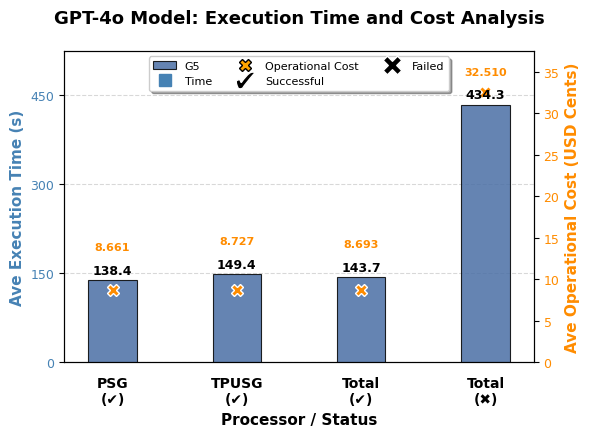


Plot saved as 'mpu_cost_time_chart.pdf'


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

# Color palette
COLORS = {
    "primary": "#4a6fa5",
    "secondary": "#28a745",
    "accent": "darkorange",
    "bg": "#ffffff",
    "text": "#000000",
}

# Data setup
keys = processor_order + ["total", "total_x"]
categories = [f"{PROCESSOR_LABELS.get(p, p)}\n(✔)" for p in processor_order] + ["Total\n(✔)", "Total\n(✖)"]
primary_label = MODEL_LABELS.get(primary_model, primary_model)
secondary_label = MODEL_LABELS.get(secondary_model, secondary_model) if secondary_model else None

# Extract metrics as arrays
def extract_metrics(stats, keys):
    return (
        np.array([stats["latency"].get(k, 0) for k in keys]),
        np.array([stats["cost"].get(k, 0) for k in keys])
    )

times_primary, costs_primary = extract_metrics(primary_stats, keys)
times_secondary, costs_secondary = extract_metrics(secondary_stats, keys) if secondary_stats else (np.zeros_like(times_primary), np.zeros_like(costs_primary))

# Chart dimensions (match ablation notebook)
num_categories = len(categories)
series_count = 1 + bool(secondary_stats)
fig_width = max(6.0, num_categories * 0.75)
fig_height = 4.0 + 0.12 * num_categories
font_base = 9
marker_size = 8 + (fig_width - 5.0) * 0.4
# x_positions = np.arange(len(categories))* 0.9

# Calculate axis limits
def nice_limit(value, pct_pad, step):
    return float(np.ceil(max(value, step) * (1 + pct_pad) / step) * step)

max_time = np.nanmax([times_primary.max(), times_secondary.max()])
max_cost = np.nanmax([costs_primary.max(), costs_secondary.max()])
y_max_time = nice_limit(max_time, 0.2, 5)
y_max_cost = nice_limit(max_cost, 0.15, 0.5)

# Setup figure and primary axis
x = np.arange(num_categories) * 0.9  # Match ablation notebook spacing
width = min(0.35, 0.8 / series_count)
offset = width / 2 if series_count == 2 else 0.0

fig, ax1 = plt.subplots(figsize=(fig_width, fig_height))
fig.patch.set_facecolor("white")
ax1.set_facecolor(COLORS["bg"])

# Plot bars
bars_primary = ax1.bar(x + offset, times_primary, width, color=COLORS["primary"], edgecolor="black", linewidth=0.8, alpha=0.85, zorder=3, label=f"{primary_label}")
bars_secondary = ax1.bar(x - offset, times_secondary, width, color=COLORS["secondary"], edgecolor="black", linewidth=0.8, alpha=0.85, zorder=3, label=f"{secondary_label}") if secondary_stats else []

# Configure primary axis (time)
ax1.set_ylabel("Ave Execution Time (s)", fontsize=font_base + 2, fontweight='bold', color='steelblue')
ax1.set_ylim(0, y_max_time)
ax1.set_xticks(x)
ax1.set_xticklabels(categories, fontsize=font_base + 1, fontweight='bold')
ax1.tick_params(axis="y", labelsize=font_base, labelcolor='steelblue')
ax1.tick_params(axis="x", length=0, pad=10)
ax1.grid(axis="y", linestyle="--", alpha=0.3, color="gray", zorder=0)
ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))

# Set x-axis limits to eliminate edge gaps
ax1.set_xlim(-width, x[-1] + width)
 
# Configure secondary axis (cost)
ax2 = ax1.twinx()
ax2.set_ylabel("Ave Operational Cost (USD Cents)", fontsize=font_base + 2, fontweight='bold', color='darkorange')
ax2.set_ylim(0, y_max_cost)
ax2.tick_params(axis="y", labelsize=font_base, labelcolor='darkorange')

# Add cost markers and labels
# Track all placed cost label positions to avoid overlaps
placed_cost_labels = []

def add_annotations(bars, times, costs):
    if not bars:
        return
    cost_y_positions = (costs / y_max_cost * y_max_time) if y_max_cost else np.zeros_like(costs)
    
    for idx, (bar, time, cost, cost_y) in enumerate(zip(bars, times, costs, cost_y_positions), start=1):
        x_center = bar.get_x() + bar.get_width() / 2
        
        # Cost marker
        ax1.plot(x_center, cost_y, marker="X", color=COLORS["accent"], markersize=marker_size, 
                 markeredgecolor="white", markeredgewidth=1, zorder=5)
        
        # Calculate time label position
        time_label_y = bar.get_height() + y_max_time * 0.01
        
        # Calculate initial cost label position
        label_y = cost_y + (y_max_time * (0.1 if cost_y < y_max_time * 0.15 and idx == 2 else 0.04))
        
        # Text height is approximately 0.06-0.08 of y_max_time depending on font size
        text_height_estimate = y_max_time * 0.08
        overlap_threshold = text_height_estimate * 1.2  # 20% margin
        
        # ═══════════════════════════════════════════════════════════════
        # COLLISION AVOIDANCE #1: Check for overlap with time label
        # ═══════════════════════════════════════════════════════════════
        if abs(label_y - time_label_y) < overlap_threshold:
            # If cost label is below or at same level as time label, move it up
            if label_y <= time_label_y + overlap_threshold * 0.3:
                label_y = time_label_y + overlap_threshold
            # If cost label is slightly above time label, move it further up
            else:
                label_y = time_label_y + overlap_threshold
        # ═══════════════════════════════════════════════════════════════
        
        # ═══════════════════════════════════════════════════════════════
        # COLLISION AVOIDANCE #2: Check for overlap with other cost labels
        # ═══════════════════════════════════════════════════════════════
        horizontal_threshold = width * 1.5  # Check labels within this x-distance
        max_attempts = 10
        for attempt in range(max_attempts):
            has_overlap = False
            for placed_x, placed_y in placed_cost_labels:
                x_dist = abs(x_center - placed_x)
                y_dist = abs(label_y - placed_y)
                # Check if labels are close horizontally and overlapping vertically
                if x_dist < horizontal_threshold and y_dist < overlap_threshold:
                    has_overlap = True
                    # Move label up to avoid overlap
                    label_y = placed_y + overlap_threshold
                    break
            if not has_overlap:
                break
        # ═══════════════════════════════════════════════════════════════
        
        # ═══════════════════════════════════════════════════════════════
        # UPPER LIMIT CHECK: If label is pushed too high, position it below marker instead
        # ═══════════════════════════════════════════════════════════════
        max_label_height = y_max_time * 0.95  # Don't allow labels above 85% of chart height
        if label_y > max_label_height:
            # Position label below the cost marker instead
            label_y = cost_y - (y_max_time * 0.05)
            # Ensure it doesn't go below 0
            label_y = max(label_y, y_max_time * 0.02)
        # ═══════════════════════════════════════════════════════════════
        
        # Store this label's position
        placed_cost_labels.append((x_center, label_y))

        ax1.text(x_center, label_y, f"{cost:.3f}", ha="center", va="center", fontsize=font_base - 1,
                 fontweight="bold", color=COLORS["accent"], 
                 bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="none", alpha=0.8), zorder=6)
        
        # Time label
        ax1.text(x_center, time_label_y, f"{time:.1f}", 
                 ha="center", va="bottom", fontsize=font_base, fontweight="bold", color=COLORS["text"], zorder=5)

add_annotations(bars_secondary, times_secondary, costs_secondary)
add_annotations(bars_primary, times_primary, costs_primary)

# Add title
if secondary_label:
    title_text = f'GPT-4o vs GPT-4o-mini:\n Execution Time and Cost Comparison'
else:
    title_text = f'GPT-4o Model: Execution Time and Cost Analysis'
ax1.set_title(title_text, fontsize=font_base + 4, fontweight='bold', pad=20)

# Set x-axis label
ax1.set_xlabel('Processor / Status', fontsize=font_base + 2, fontweight='bold')

# Legend
handles1, labels1 = ax1.get_legend_handles_labels()
time_legend = Line2D([0], [0], color='steelblue', marker='s', linestyle='', 
                     markersize=marker_size, label='Time', markerfacecolor='steelblue')
cost_legend = Line2D([0], [0], marker='X', color='w', markerfacecolor='orange', 
                     markersize=marker_size, markeredgecolor='black', label='Operational Cost')
success_legend = Line2D([0], [0], marker="$✔$", color="w", mfc="black", ms=marker_size + 5, label="Successful")
fail_legend = Line2D([0], [0], marker="$✖$", color="w", mfc="black", ms=marker_size + 5, label="Failed")

all_handles = handles1 + [time_legend, cost_legend, success_legend, fail_legend]
all_labels = labels1 + ['Time', 'Operational Cost', 'Successful', 'Failed']

ax1.legend(all_handles, all_labels, loc='upper center', fontsize=font_base - 1, 
           title_fontsize=font_base, frameon=True, fancybox=True, shadow=True, ncol=3)

plt.tight_layout()
plt.savefig("figs/g4o_mpu_cost_time_chart.pdf", dpi=300, bbox_inches="tight")
plt.show()

print("\nPlot saved as 'mpu_cost_time_chart.pdf'")
